<a href="https://colab.research.google.com/github/jacksone1/DataSci/blob/main/DataSciUnit3Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#Install and import datasets and preliz libraries
!pip install datasets
from datasets import load_dataset

!pip install preliz
import preliz as pz

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.9/509.9 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 19.3 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of 

In [3]:
#Import other libraries
import numpy as np
import arviz as az
import pymc as pm
import pandas as pd
import random as rd

In the game Super Mario Maker 2, players are given the ability to design their own Mario levels and share them online. Each level can be customized in a variety of ways, one of which is the level theme. Players may choose between ten different aesthetic themes for their levels: overworld, underground, castle, airship, underwater, ghost house, snow, desert, sky, and forest. The themes are assigned numbers below.

In [4]:
course_themes = {
    0: "Overworld",
    1: "Underground",
    2: "Castle",
    3: "Airship",
    4: "Underwater",
    5: "Ghost house",
    6: "Snow",
    7: "Desert",
    8: "Sky",
    9: "Forest"
}

My goal is to predict the probability of a player selecting each one of the theme options. A choice of theme is a 10-way event, so I will use a categorical likelihood, "the most general distribution over a k-way event" (Wikipedia). The prior for a categorical distribution is a dirichlet distribution: a multivariate generalization of the beta distribution such that the sum of its variables are always equal to one. Each dimension will represent one of the theme categories.
The dirichlet prior will be defined by the mode of the distribution in each dimension, as well as the proportion of the probability mass within a certain + - bound from the mode. The modes must sum to one, as a certain outcome of the prior is a vector of probabilities for each theme and there cannot be multiple themes selected at once. I am not entirely certain how popular each of these themes will be relative to one another, so I have chosen to keep my prior weak by concentrating relatively low amounts of mass around the mode and allowing the large dataset to have greater impact on the posterior predictions. I believe Overworld and Castle will be the most popular at probabilities of .2, followed by Underground at .15, as those are the most iconic types of mario levels. Airship, Underwater, Snow, Desert, and Sky are the themes I think will be the least popular, so I set their modes to 0.05.

Dirichlet(mean=array([0.13268647, 0.11634324, 0.13268647, 0.08365676, 0.08365676,
       0.1       , 0.08365676, 0.08365676, 0.08365676, 0.1       ]), std=array([0.08519352, 0.08052255, 0.08519352, 0.06953201, 0.06953201,
       0.07534014, 0.06953201, 0.06953201, 0.06953201, 0.07534014]))

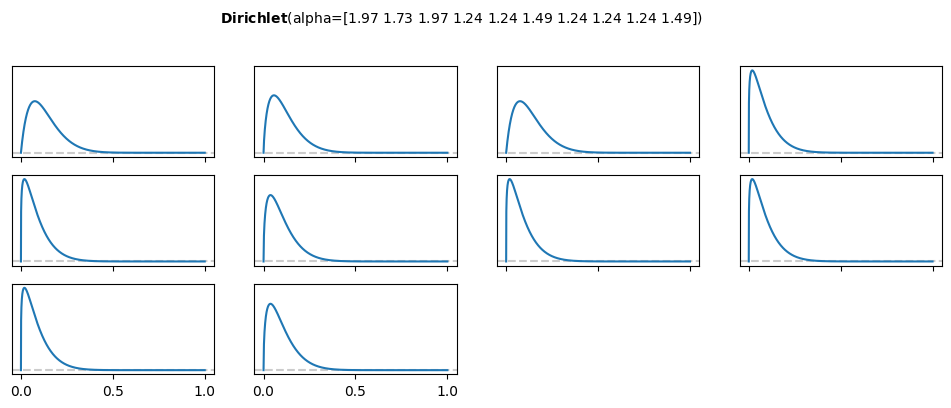

In [5]:
#Define and plot the prior probability density function
prior_pdf = pz.dirichlet_mode(mode=[0.2, 0.15, 0.2, 0.05, 0.05, 0.1, 0.05, 0.05, 0.05, 0.1], mass=0.4, bound=0.04)[1]
#Print the means and standard deviations of each dimension of the distribution
prior_pdf.summary()

The Mario Maker 2 data used for this project was acquired from https://huggingface.co/datasets/TheGreatRambler/mm2_level. The dataset contains a variety of information about player uploaded levels, including the game theme.

The dataset is too large to load quickly in its entirety, so it is loaded in streaming mode, which means only part of the dataset is loaded at a time. 1000 entries of level data are acquired and shuffled, before theme number is recorded in a numpy array. The categorical distribution for the data will be plotted.

The random seed used for acquiring the data was generated from Random.org's random integer generator from 1 to 100 (both inclusive) at 2024-10-17 18:14:11 UTC

Resolving data files:   0%|          | 0/196 [00:00<?, ?it/s]

<Axes: >

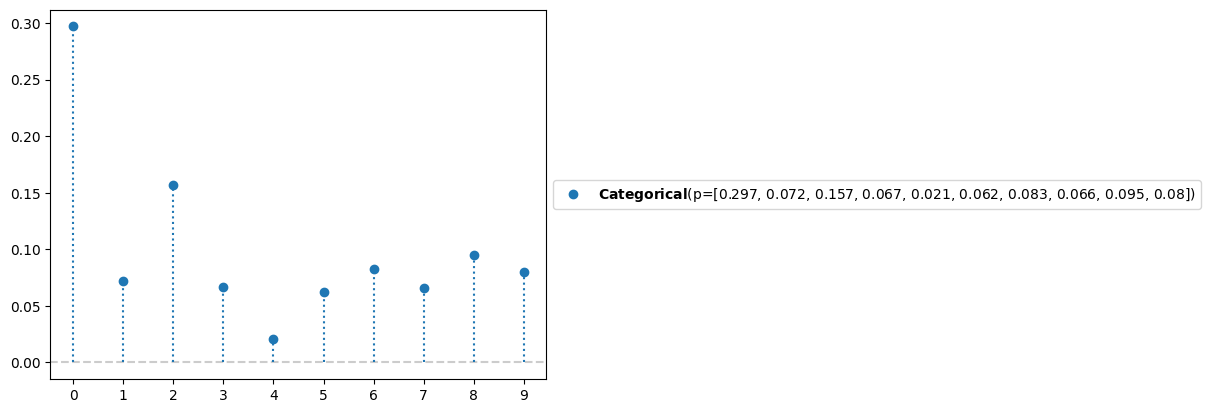

In [17]:
#Read Mario Maker data
mario_levels = load_dataset("TheGreatRambler/mm2_level", streaming=True, split="train")
#Shuffle data
shuffled_levels = mario_levels.shuffle(buffer_size=1_000, seed=90)
#Get the data as a list to iterate over
sample = list(shuffled_levels.take(1000))
#Create a zeroed numpy array matching the size of the list
theme_data = np.zeros(1000)
#Create an array of probabilities by category
category_probabilities = np.zeros(10)
#For each element of the list, record the theme number in the Numpy array
for i in range(0, 1000):
  theme_data[i] = sample[i]["theme"]
  category_probabilities[sample[i]["theme"]] += 1/1000
#Display the category Numpy array with a categorical distribution
pz.Categorical(category_probabilities).plot_pdf()

The pymc model will be created based on the previously explained prior and likelihood. 1000 samples will be drawn from the model.

In [18]:
#Create Mario Maker theme model
with pm.Model() as mm_theme_model:
  #Set the prior distribution
  θ = pm.Dirichlet('θ', prior_pdf.alpha)

  #Define the likelihood using the prior and the previously collected level data
  y = pm.Categorical('y', p = θ, observed = theme_data)

  #Sample from the posterior model
  idata_theme = pm.sample(1000)

#vizualize the 1000 samples from the pymc model of the posterior
#az.plot_posterior(idata_theme)

Output()

Output()

In [19]:
#Use the posterior samples and the model to predict future level styles
pm.sample_posterior_predictive(idata_theme, model=mm_theme_model, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

In [ ]:
course_themes = {
    0: "Overworld",
    1: "Underground",
    2: "Castle",
    3: "Airship",
    4: "Underwater",
    5: "Ghost house",
    6: "Snow",
    7: "Desert",
    8: "Sky",
    9: "Forest"
}

The posterior predictive check reveals that the posterior predictive mean aligns closely with the observed data. The predictions for zero vary highly, while the predictions for four vary little. The predictions for two and three are right skewed, as can be observed in the strong concentration of predictions above the mean. The predictions for seven and nine appear to be bimodal because there are strong concentrations above and below the mean. We can be fairly confident in the predictions, as the mean approximates the observations and the variation is small for the majority of the level themes.

The random seed used for the check was generated from Random.org's random integer generator from 1 to 100 (both inclusive) at 2024-10-10 18:40:39 UTC.

<Axes: xlabel='y'>

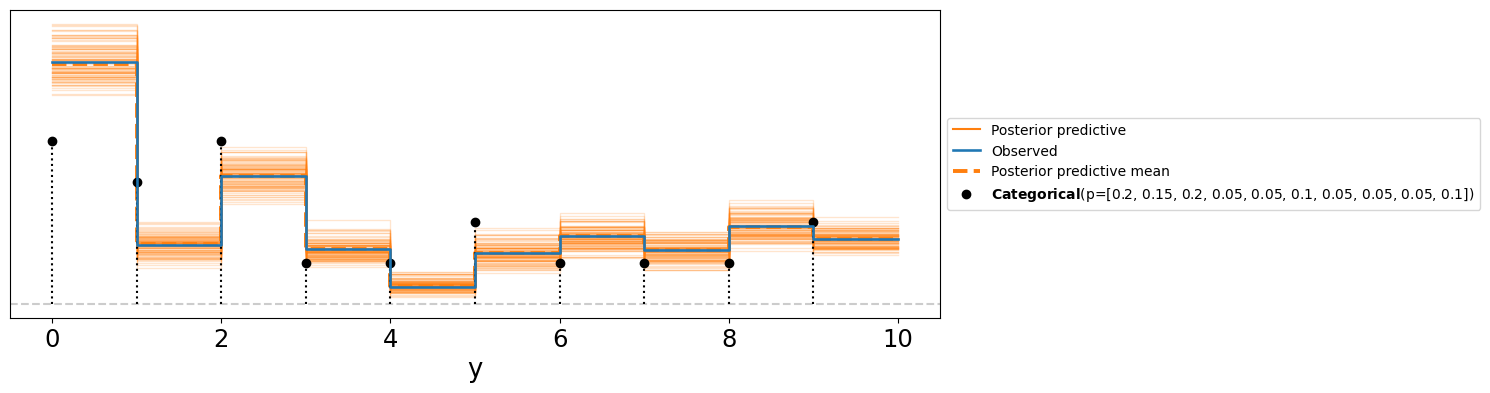

In [20]:
#Plot the posterior predictive check
az.plot_ppc(idata_theme, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"], random_seed=36)
#Plot prior modes for reference
pz.Categorical([0.2, 0.15, 0.2, 0.05, 0.05, 0.1, 0.05, 0.05, 0.05, 0.1]).plot_pdf(color="k")

The 0 category, the default and most basic theme, Overworld, is the most likely to be picked by far, though it is not clear by exactly how much. The second most likely appears to be 2, the Castle theme, though the size of its lead varies. 8, Sky, is next, then 6 and 9, Snow and Forest, are similarly likely. Below are 1, 3, 5, and 7, Underground, Airship, Ghost House, and Desert, which are also similarly likely. 4, Underwater, is the least likely and has the least variance among the predictions.

My prior was defined by the following modes: [0.2, 0.15, 0.2, 0.05, 0.05, 0.1, 0.05, 0.05, 0.05, 0.1]. I was right in assuming Overworld and Castle were the most likely, but Overworld is predicted to be far more likely than the other options. Underground, Castle, Underwater, and Ghost House were all less likely to be chosen than I thought. I did not assume Underwater would be the least popular.